# Huntington Candidates Analysis

This notebook evaluates drug candidates for Huntington's Disease by scoring them against:
1. Huntington Protein (HTT)
2. Huntington Disease

We analyze the ranking of candidates based on their PROTON scores and overlay their PubChem activity outcomes.

In [1]:
import logging
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Setup logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
_logger = logging.getLogger(__name__)

# --- Path Setup ---
def _find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for parent in (start, *start.parents):
        if (parent / "pyproject.toml").exists():
            return parent
    return start

PROJECT_ROOT = _find_repo_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
    
# Change working directory to root for correct config loading
os.chdir(PROJECT_ROOT)

from src.config import conf
from src.constants import TORCH_DEVICE
from src.dataloaders import load_graph
from src.models import HGT

_logger.info(f"Working from: {os.getcwd()}")
_logger.info(f"Device: {TORCH_DEVICE}")

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "sans-serif"

[02/05/26 00:37:09] INFO     Working from: /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM      ]8;id=540089;file:///tmp/ipykernel_830620/138076137.py\138076137.py]8;;\:]8;id=741254;file:///tmp/ipykernel_830620/138076137.py#37\37]8;;\

                    INFO     Device: cuda                                                           ]8;id=567095;file:///tmp/ipykernel_830620/138076137.py\138076137.py]8;;\:]8;id=685097;file:///tmp/ipykernel_830620/138076137.py#38\38]8;;\

In [2]:
# 1. Load Nodes and Edges
_logger.info("Loading graph structure...")
nodes = pd.read_csv(conf.paths.kg.nodes_path, dtype={"node_index": int}, low_memory=False)
edges = pd.read_csv(
    conf.paths.kg.edges_path, 
    dtype={"edge_index": int, "x_index": int, "y_index": int}, 
    low_memory=False
)
kg = load_graph(nodes, edges)

# 2. Load Pretrained Model
_logger.info("Loading PROTON model...")
pretrain_model = HGT.load_from_checkpoint(
    checkpoint_path=str(conf.paths.checkpoint.checkpoint_path),
    kg=kg,
    strict=False,
)
pretrain_model.eval()
pretrain_model = pretrain_model.to(TORCH_DEVICE)

# 3. Load Pretrained Embeddings
_logger.info("Loading pretrained embeddings...")
pretrained_embeddings = torch.load(conf.paths.checkpoint.embeddings_path, map_location='cpu')
_logger.info(f"Pretrained embeddings shape: {pretrained_embeddings.shape}")

                    INFO     Loading graph structure...                                             ]8;id=976998;file:///tmp/ipykernel_830620/1418713357.py\1418713357.py]8;;\:]8;id=974178;file:///tmp/ipykernel_830620/1418713357.py#2\2]8;;\

[02/05/26 00:37:35] INFO     Loading PROTON model...                                               ]8;id=187256;file:///tmp/ipykernel_830620/1418713357.py\1418713357.py]8;;\:]8;id=140233;file:///tmp/ipykernel_830620/1418713357.py#12\12]8;;\

[02/05/26 00:37:57] INFO     Loading pretrained embeddings...                                      ]8;id=985171;file:///tmp/ipykernel_830620/1418713357.py\1418713357.py]8;;\:]8;id=853878;file:///tmp/ipykernel_830620/1418713357.py#22\22]8;;\

                    INFO     Pretrained embeddings shape: torch.Size([147020, 512])                ]8;id=549746;file:///tmp/ipykernel_830620/1418713357.py\1418713357.py]8;;\:]8;id=655113;file:///tmp/ipykernel_830620/1418713357.py#24\24]8;;\

In [3]:
# Identify Targets
# 1. Huntington Protein (HTT)
protein_nodes = nodes[nodes['node_type'] == 'gene/protein']
htt_target = protein_nodes[nodes['node_name'] == 'HTT']

if len(htt_target) == 0:
    _logger.warning("Exact match for 'HTT' not found. Searching contains...")
    htt_target = protein_nodes[nodes['node_name'].str.contains('HTT', case=False)]

if len(htt_target) > 0:
    htt_idx = htt_target.iloc[0]['node_index']
    htt_name = htt_target.iloc[0]['node_name']
    _logger.info(f"Found Protein Target: {htt_name} (Index: {htt_idx})")
else:
    raise ValueError("Could not find HTT protein in graph.")

# 2. Huntington Disease
disease_nodes = nodes[nodes['node_type'] == 'disease']
hd_target = disease_nodes[disease_nodes['node_name'].str.contains("Huntington", case=False)]

print("Found disease nodes matching 'Huntington':")
display(hd_target[['node_name', 'node_index']].head())

if len(hd_target) > 0:
    # Pick the most specific one, usually "Huntington disease"
    exact_match = hd_target[hd_target['node_name'].str.lower() == "huntington disease"]
    if len(exact_match) > 0:
        hd_idx = exact_match.iloc[0]['node_index']
        hd_name = exact_match.iloc[0]['node_name']
    else:
         hd_idx = hd_target.iloc[0]['node_index']
         hd_name = hd_target.iloc[0]['node_name']
    
    _logger.info(f"Selected Disease Target: {hd_name} (Index: {hd_idx})")
else:
    raise ValueError("Could not find Huntington disease in graph.")

[02/05/26 00:37:58] WARNING  /tmp/ipykernel_830620/577901598.py:4: UserWarning: Boolean Series key  ]8;id=203662;file:///usr/lib64/python3.11/warnings.py\warnings.py]8;;\:]8;id=886284;file:///usr/lib64/python3.11/warnings.py#110\110]8;;\
                             will be reindexed to match DataFrame index.                                           
                               htt_target = protein_nodes[nodes['node_name'] == 'HTT']                             
                                                                                                                   

                    INFO     Found Protein Target: HTT (Index: 2754)                                ]8;id=449686;file:///tmp/ipykernel_830620/577901598.py\577901598.py]8;;\:]8;id=110994;file:///tmp/ipykernel_830620/577901598.py#13\13]8;;\

Found disease nodes matching 'Huntington':


,node_name,node_index
29909,Huntington disease,29909
30040,Huntington disease-like 2,30040
30409,Huntington disease-like 1,30409
32625,Huntington disease-like 3,32625
35976,Huntington disease-like syndrome due to C9ORF7...,35976


                    INFO     Selected Disease Target: Huntington disease (Index: 29909)             ]8;id=232694;file:///tmp/ipykernel_830620/577901598.py\577901598.py]8;;\:]8;id=998863;file:///tmp/ipykernel_830620/577901598.py#34\34]8;;\

In [4]:
# Load Candidate Embeddings and Metadata
candidates_emb_path = PROJECT_ROOT / "notebooks/molecular_analysis/huntington_candidates_embeddings.pt"
candidates_csv_path = PROJECT_ROOT / "notebooks/molecular_analysis/huntington_candidates_filtered_molecules_with_embeddings.csv"

_logger.info(f"Loading candidate embeddings from {candidates_emb_path}")
res_embeddings = torch.load(candidates_emb_path, map_location='cpu')

_logger.info(f"Loading candidate metadata from {candidates_csv_path}")
candidates_df = pd.read_csv(candidates_csv_path)

_logger.info(f"Embeddings shape: {res_embeddings.shape}")
_logger.info(f"Metadata shape: {candidates_df.shape}")

# Ensure alignment
if len(res_embeddings) != len(candidates_df):
    _logger.warning(f"Length mismatch! Embeddings: {len(res_embeddings)}, Metadata: {len(candidates_df)}")
    # Assuming they are aligned and taking common length
    min_len = min(len(res_embeddings), len(candidates_df))
    res_embeddings = res_embeddings[:min_len]
    candidates_df = candidates_df.iloc[:min_len]
    _logger.info(f"Trimmed to {min_len} candidates.")

# --- Filter for Actives Only (Exclude Inactive/Inconclusive) ---
if 'pubchem_activity_outcome' in candidates_df.columns:
    _logger.info("Filtering for ACTIVE compounds only...")
    outcomes = candidates_df['pubchem_activity_outcome'].astype(str).str.strip().str.lower()
    
    # Keep only actives
    active_mask = (outcomes == 'active')
    active_indices = np.where(active_mask)[0]
    
    candidates_df = candidates_df.iloc[active_indices].reset_index(drop=True)
    res_embeddings = res_embeddings[active_indices]
    
    _logger.info(f"Filtered to {len(candidates_df)} ACTIVE candidates.")
else:
    _logger.warning("Column 'pubchem_activity_outcome' not found. Skipping filtering.")

# Combine Embeddings for Model Lookup
# We append candidate embeddings to the pretrained ones
combined_embeddings = torch.cat([pretrained_embeddings, res_embeddings], dim=0)
num_pretrained = len(pretrained_embeddings)
candidate_indices = torch.arange(num_pretrained, num_pretrained + len(res_embeddings), dtype=torch.long)

_logger.info(f"Combined embeddings shape: {combined_embeddings.shape}")

                    INFO     Loading candidate embeddings from                                       ]8;id=504432;file:///tmp/ipykernel_830620/555441538.py\555441538.py]8;;\:]8;id=868662;file:///tmp/ipykernel_830620/555441538.py#5\5]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/notebooks/molecular               
                             _analysis/huntington_candidates_embeddings.pt                                         

                    INFO     Loading candidate metadata from                                         ]8;id=845396;file:///tmp/ipykernel_830620/555441538.py\555441538.py]8;;\:]8;id=63072;file:///tmp/ipykernel_830620/555441538.py#8\8]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/notebooks/molecular               
                             _analysis/huntington_candidates_filtered_molecules_with_embeddings.csv                

                    INFO     Embeddings shape: torch.Size([906, 512])                               ]8;id=429995;file:///tmp/ipykernel_830620/555441538.py\555441538.py]8;;\:]8;id=111934;file:///tmp/ipykernel_830620/555441538.py#11\11]8;;\

                    INFO     Metadata shape: (906, 41)                                              ]8;id=890376;file:///tmp/ipykernel_830620/555441538.py\555441538.py]8;;\:]8;id=604004;file:///tmp/ipykernel_830620/555441538.py#12\12]8;;\

                    INFO     Filtering for ACTIVE compounds only...                                 ]8;id=293586;file:///tmp/ipykernel_830620/555441538.py\555441538.py]8;;\:]8;id=63834;file:///tmp/ipykernel_830620/555441538.py#25\25]8;;\

                    INFO     Filtered to 55 ACTIVE candidates.                                      ]8;id=639905;file:///tmp/ipykernel_830620/555441538.py\555441538.py]8;;\:]8;id=564659;file:///tmp/ipykernel_830620/555441538.py#35\35]8;;\

                    INFO     Combined embeddings shape: torch.Size([147075, 512])                   ]8;id=615016;file:///tmp/ipykernel_830620/555441538.py\555441538.py]8;;\:]8;id=367319;file:///tmp/ipykernel_830620/555441538.py#45\45]8;;\

In [5]:
# Compute Scores

# Function to compute scores
def compute_scores(target_idx, target_type, relation_type):
    # We want Score(Candidate -> Target)
    # Edge: (Drug, relation, TargetType)
    
    canonical_etypes = kg.canonical_etypes
    etype = None
    
    # Try forward: Drug -> Target
    for et in canonical_etypes:
        # Check source is drug and target fits
        if et[0] == 'drug' and et[2] == target_type and relation_type in et[1]:
            etype = et
            break
            
    if etype is None:
        _logger.error(f"Could not find edge type for Drug -> {target_type} with relation {relation_type}")
        return None

    _logger.info(f"Scoring using edge: {etype}")
    
    batch_src = candidate_indices # Drugs
    batch_dst = torch.full((len(candidate_indices),), target_idx, dtype=torch.long) # Target
    
    with torch.no_grad():
        scores = pretrain_model.get_scores_from_embeddings(
            batch_src, 
            batch_dst, 
            etype, 
            embeddings=combined_embeddings, 
            use_cache=False, 
            query_kg=kg
        )
    return scores.cpu().numpy()

# 1. Score Candidate -> HTT Protein
_logger.info("Scoring against Huntington Protein (HTT)...")
htt_scores = compute_scores(htt_idx, 'gene/protein', 'drug_protein')

# 2. Score Candidate -> Huntington Disease
_logger.info("Scoring against Huntington Disease...")
hd_scores = compute_scores(hd_idx, 'disease', 'rev_indication')

# Add to DataFrame
candidates_df['Score_HTT'] = htt_scores
candidates_df['Score_HD'] = hd_scores

display(candidates_df[['pubchem_result_tag', 'pubchem_activity_outcome', 'Score_HTT', 'Score_HD']].head())

                    INFO     Scoring against Huntington Protein (HTT)...                            ]8;id=351574;file:///tmp/ipykernel_830620/120323749.py\120323749.py]8;;\:]8;id=589417;file:///tmp/ipykernel_830620/120323749.py#39\39]8;;\

                    INFO     Scoring using edge: ('drug', 'drug_protein', 'gene/protein')           ]8;id=897684;file:///tmp/ipykernel_830620/120323749.py\120323749.py]8;;\:]8;id=743782;file:///tmp/ipykernel_830620/120323749.py#22\22]8;;\

[02/05/26 00:37:59] INFO     Scoring against Huntington Disease...                                  ]8;id=542048;file:///tmp/ipykernel_830620/120323749.py\120323749.py]8;;\:]8;id=809783;file:///tmp/ipykernel_830620/120323749.py#43\43]8;;\

                    INFO     Scoring using edge: ('drug', 'rev_indication', 'disease')              ]8;id=288355;file:///tmp/ipykernel_830620/120323749.py\120323749.py]8;;\:]8;id=467299;file:///tmp/ipykernel_830620/120323749.py#22\22]8;;\

,pubchem_result_tag,pubchem_activity_outcome,Score_HTT,Score_HD
0,1,Active,0.212267,0.899010
1,2,Active,0.249315,0.943508
2,3,Active,0.228333,0.938985
3,4,Active,0.258336,0.881615
4,5,Active,0.221717,0.943956


In [6]:
# 1. Identify NeuroKG Drugs and Score them
_logger.info("Scoring all NeuroKG drugs to find background set...")

# Get all drug nodes from the graph
drug_nodes_df = nodes[nodes['node_type'] == 'drug']
drug_indices_kg = torch.tensor(drug_nodes_df['node_index'].values, dtype=torch.long)

# Helper function for KG scoring (using pretrained_embeddings directly)
def compute_kg_scores(target_idx, target_type, relation_type, source_indices):
    canonical_etypes = kg.canonical_etypes
    etype = None
    for et in canonical_etypes:
        # Check source is drug and target fits
        if et[0] == 'drug' and et[2] == target_type and relation_type in et[1]:
            etype = et
            break
            
    if etype is None:
        _logger.error(f"Could not find edge type for Drug -> {target_type} with relation {relation_type}")
        return None
    
    batch_src = source_indices.to(TORCH_DEVICE)
    batch_dst = torch.full((len(source_indices),), target_idx, dtype=torch.long).to(TORCH_DEVICE)
    
    # Ensure embeddings are on device for calculation
    # We use pretrained_embeddings directly as these correspond to graph node indices
    emb_device = pretrained_embeddings.to(TORCH_DEVICE)
    
    with torch.no_grad():
        scores = pretrain_model.get_scores_from_embeddings(
            batch_src, 
            batch_dst, 
            etype, 
            embeddings=emb_device, 
            use_cache=False, 
            query_kg=kg
        )
    return scores.cpu().numpy()

# Score KG Drugs
kg_scores_htt = compute_kg_scores(htt_idx, 'gene/protein', 'drug_protein', drug_indices_kg)
kg_scores_hd = compute_kg_scores(hd_idx, 'disease', 'rev_indication', drug_indices_kg)

# Create DataFrame for KG drugs
kg_drugs_df = pd.DataFrame({
    'node_index': drug_nodes_df['node_index'].astype(int).values,
    'Score_HTT': kg_scores_htt,
    'Score_HD': kg_scores_hd,
    'pubchem_activity_outcome': 'neurokg_background'
})

# Filter: Score < 0.5 for BOTH
htt_q25 = kg_drugs_df["Score_HTT"].quantile(1.0)
hd_q25 = kg_drugs_df["Score_HD"].quantile(1.0)

background_mask = (kg_drugs_df["Score_HTT"] <= htt_q25) & (kg_drugs_df["Score_HD"] <= hd_q25)
filtered_bg_drugs = kg_drugs_df[background_mask].copy()

_logger.info(f"Total NeuroKG Drugs: {len(kg_drugs_df)}")
_logger.info(f"Background Drugs (Score < 0.5 for both): {len(filtered_bg_drugs)}")

# Combine with Candidates
# We only need specific columns for the plot
plot_cols = ['Score_HTT', 'Score_HD', 'pubchem_activity_outcome']
combined_ranking_df = pd.concat([
    candidates_df[plot_cols],
    filtered_bg_drugs[plot_cols]
], ignore_index=True)

_logger.info(f"Combined DataFrame for ranking: {len(combined_ranking_df)} rows")
display(combined_ranking_df.head())

                    INFO     Scoring all NeuroKG drugs to find background set...                    ]8;id=835440;file:///tmp/ipykernel_830620/2951657007.py\2951657007.py]8;;\:]8;id=166226;file:///tmp/ipykernel_830620/2951657007.py#2\2]8;;\

[02/05/26 00:38:00] INFO     Total NeuroKG Drugs: 8160                                             ]8;id=514423;file:///tmp/ipykernel_830620/2951657007.py\2951657007.py]8;;\:]8;id=623563;file:///tmp/ipykernel_830620/2951657007.py#59\59]8;;\

                    INFO     Background Drugs (Score < 0.5 for both): 8160                         ]8;id=156627;file:///tmp/ipykernel_830620/2951657007.py\2951657007.py]8;;\:]8;id=742954;file:///tmp/ipykernel_830620/2951657007.py#60\60]8;;\

                    INFO     Combined DataFrame for ranking: 8215 rows                             ]8;id=142714;file:///tmp/ipykernel_830620/2951657007.py\2951657007.py]8;;\:]8;id=11684;file:///tmp/ipykernel_830620/2951657007.py#70\70]8;;\

,Score_HTT,Score_HD,pubchem_activity_outcome
0,0.212267,0.899010,Active
1,0.249315,0.943508,Active
2,0.228333,0.938985,Active
3,0.258336,0.881615,Active
4,0.221717,0.943956,Active


In [8]:
# --- Ranking curve utility ---
# Plots a monotonically-decreasing rank-vs-score curve (sorted by score), and overlays
# vertical lines at ranks corresponding to "hits" (e.g., PubChem actives).

from pathlib import Path

def plot_monotonically_decreasing(
    df: pd.DataFrame,
    score_col: str,
    title: str,
    filename: str,
    *,
    outcome_col: str = "pubchem_activity_outcome",
    hit_values: tuple[str, ...] = ("active",),
    hit_label: str = "Hits",
    hit_color: str = "#E74C3C",
    hit_alpha: float = 0.6,
    curve_color: str = "black",
    curve_lw: float = 1.5,
    figsize: tuple[int, int] = (14, 7),
    dpi: int = 300,
    save_dir: Path | None = None,
    show: bool = True,
 ):
    """Plot sorted scores (monotonically decreasing) with hit ranks highlighted.

    Args:
        df: DataFrame containing `score_col` and optionally `outcome_col`.
        score_col: Column name with scalar scores to rank by (higher = better).
        title: Plot title.
        filename: Output image filename (saved under `data/notebooks/molecular_analysis/` by default).
        outcome_col: Column containing hit labels (e.g., "active", "inactive", "neurokg_background").
        hit_values: Values in `outcome_col` considered hits (case-insensitive).
        hit_label: Legend label for highlighted hits.
        hit_color: Color for vertical hit markers.
        hit_alpha: Alpha for vertical hit markers.
        curve_color: Color for the overall rank curve.
        curve_lw: Line width for the overall rank curve.
        figsize: Figure size.
        dpi: Save DPI.
        save_dir: Override output directory; defaults to `PROJECT_ROOT/data/notebooks/molecular_analysis`.
        show: Whether to call `plt.show()`.

    Returns:
        (fig, ax) matplotlib handles.
    """
    if score_col not in df.columns:
        raise KeyError(f"Missing score column: {score_col}")

    plot_df = df.copy()
    plot_df = plot_df.dropna(subset=[score_col]).reset_index(drop=True)
    if len(plot_df) == 0:
        raise ValueError(f"No non-null values in {score_col}")

    scores = plot_df[score_col].astype(float).to_numpy()
    order = np.argsort(-scores)
    sorted_scores = scores[order]
    ranks = np.arange(len(sorted_scores))

    # Determine hit ranks (if available)
    hit_ranks = np.array([], dtype=int)
    if outcome_col in plot_df.columns:
        outcomes = plot_df[outcome_col].astype(str).str.strip().str.lower().to_numpy()
        outcomes_sorted = outcomes[order]
        hit_values_norm = {v.strip().lower() for v in hit_values}
        is_hit = np.isin(outcomes_sorted, list(hit_values_norm))
        hit_ranks = ranks[is_hit]

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(ranks, sorted_scores, color=curve_color, linewidth=curve_lw, zorder=2, label="All molecules")

    if len(hit_ranks) > 0:
        ymin = float(np.nanmin(sorted_scores))
        ymax = float(np.nanmax(sorted_scores))
        ax.vlines(
            hit_ranks,
            ymin=ymin,
            ymax=ymax,
            color=hit_color,
            alpha=hit_alpha,
            linewidth=0.9,
            zorder=3,
            label=f"{hit_label} ({len(hit_ranks)})",
        )

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Rank (0 = highest score)", fontsize=14)
    ax.set_ylabel(score_col, fontsize=14)
    ax.grid(True, which="major", axis="both", alpha=0.25)
    ax.legend(loc="upper right", fontsize=12)

    # Small annotation to make it easier to read off where hits fall
    if len(hit_ranks) > 0:
        median_hit_rank = float(np.median(hit_ranks))
        total = len(sorted_scores)
        stats_text = (
            f"Total molecules: {total}\n"
            f"Median hit rank: {median_hit_rank:.0f} ({(median_hit_rank / max(total, 1)) * 100:.1f}%)"
        )
        ax.text(
            0.02,
            0.05,
            stats_text,
            transform=ax.transAxes,
            fontsize=12,
            bbox=dict(facecolor="white", alpha=0.85, edgecolor="none"),
        )

    fig.tight_layout()

    # Save
    default_dir = Path.cwd() / "data/notebooks/molecular_analysis"
    if "PROJECT_ROOT" in globals():
        default_dir = Path(PROJECT_ROOT) / "data/notebooks/molecular_analysis"
    out_dir = Path(save_dir) if save_dir is not None else default_dir
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / filename
    fig.savefig(out_path, dpi=dpi)
    if "_logger" in globals():
        _logger.info(f"Saved ranking curve to {out_path}")
    else:
        print(f"Saved ranking curve to {out_path}")

    if show:
        plt.show()
    return fig, ax

[02/05/26 00:50:01] INFO     Plotting rankings with NeuroKG background...                           ]8;id=459718;file:///tmp/ipykernel_830620/4023352540.py\4023352540.py]8;;\:]8;id=638813;file:///tmp/ipykernel_830620/4023352540.py#2\2]8;;\

[02/05/26 00:50:03] INFO     Saved ranking curve to                                               ]8;id=11464;file:///tmp/ipykernel_830620/1463998074.py\1463998074.py]8;;\:]8;id=195681;file:///tmp/ipykernel_830620/1463998074.py#120\120]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/m                  
                             olecular_analysis/htt_ranking_curve_with_background.png                               

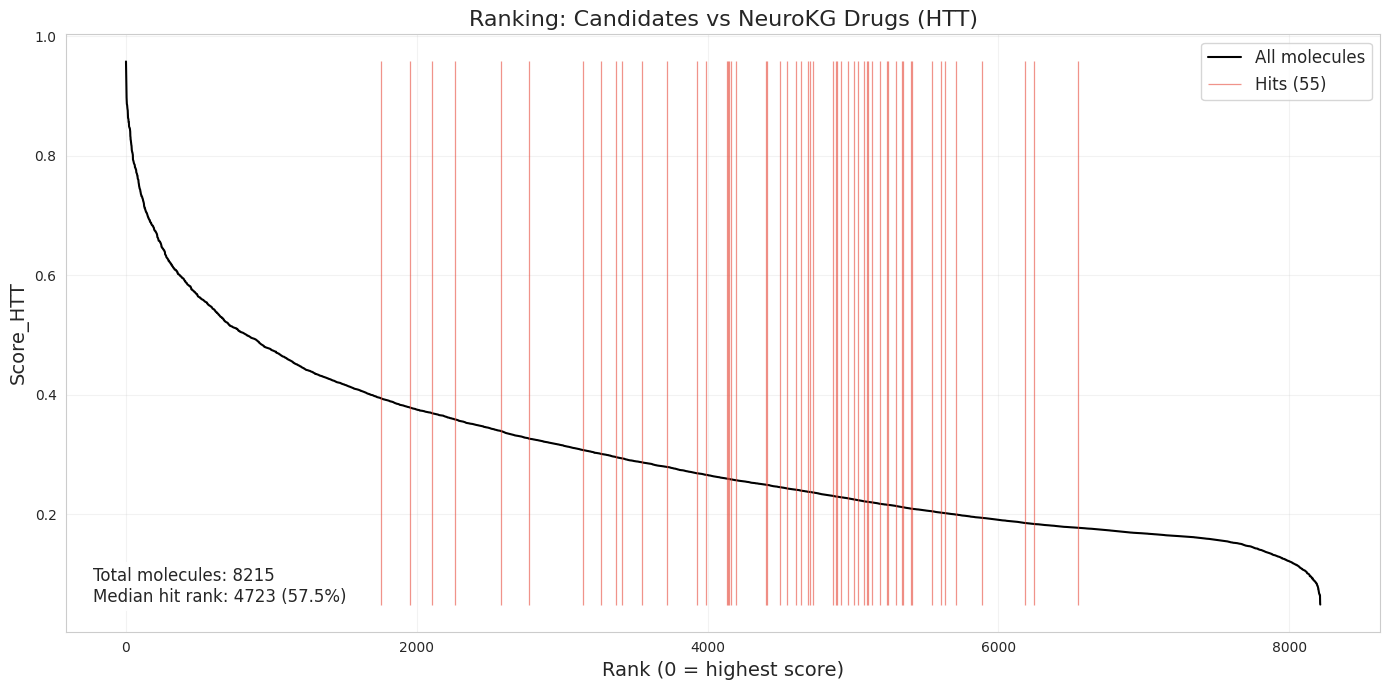

                    INFO     Saved ranking curve to                                               ]8;id=220898;file:///tmp/ipykernel_830620/1463998074.py\1463998074.py]8;;\:]8;id=170684;file:///tmp/ipykernel_830620/1463998074.py#120\120]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/m                  
                             olecular_analysis/hd_ranking_curve_with_background.png                                

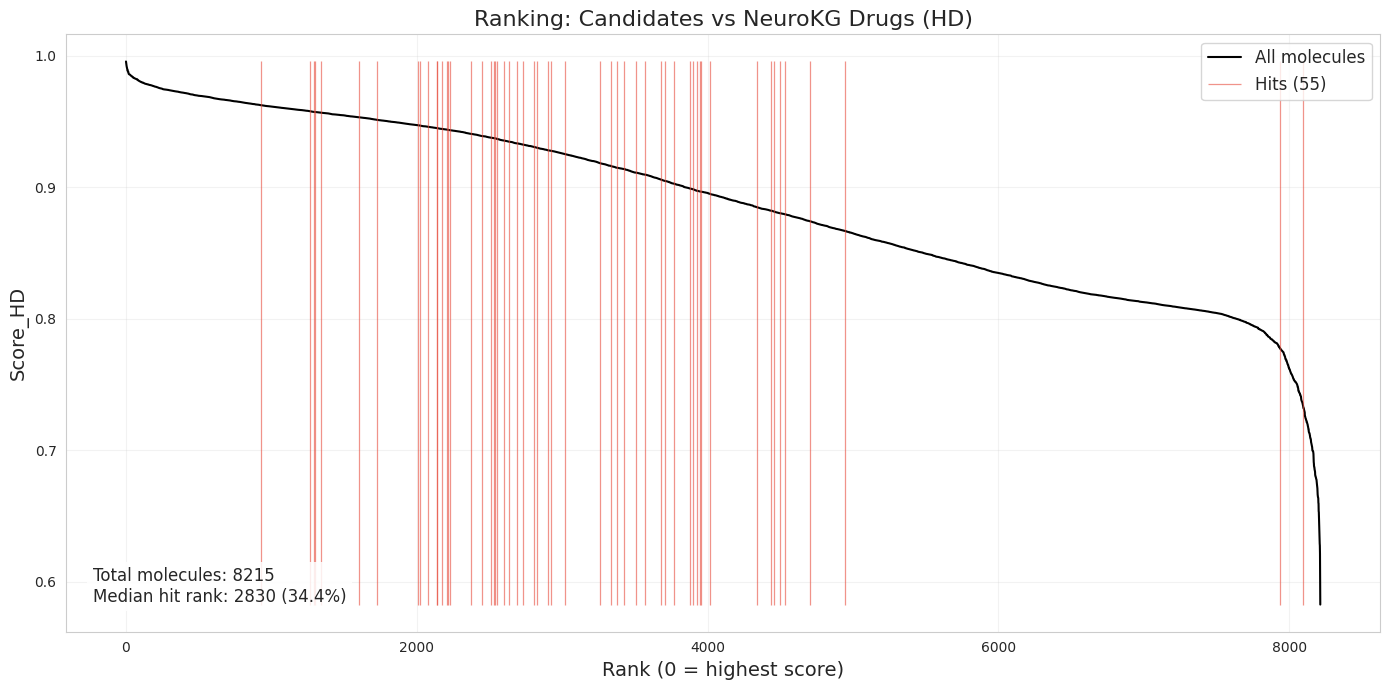


(
    <Figure size 1400x700 with 1 Axes>,
    <Axes: title={'center': 'Ranking: Candidates vs NeuroKG Drugs (HD)'}, xlabel='Rank (0 = highest score)', ylabel='Score_HD'>
)

In [9]:
# Plot Rankings with Background
_logger.info("Plotting rankings with NeuroKG background...")

# Plot HTT
plot_monotonically_decreasing(
    combined_ranking_df, 
    'Score_HTT', 
    "Ranking: Candidates vs NeuroKG Drugs (HTT)", 
    "htt_ranking_curve_with_background.png"
)

# Plot HD
plot_monotonically_decreasing(
    combined_ranking_df, 
    'Score_HD', 
    "Ranking: Candidates vs NeuroKG Drugs (HD)", 
    "hd_ranking_curve_with_background.png"
)

[02/05/26 00:50:04] INFO     Huntington disease node idx: 29909 | 1-hop drug neighbors: 21          ]8;id=837570;file:///tmp/ipykernel_830620/432465101.py\432465101.py]8;;\:]8;id=57607;file:///tmp/ipykernel_830620/432465101.py#48\48]8;;\

                    INFO     HTT node idx: 2754 | within-2-hop drug nodes: 905                      ]8;id=95064;file:///tmp/ipykernel_830620/432465101.py\432465101.py]8;;\:]8;id=954327;file:///tmp/ipykernel_830620/432465101.py#49\49]8;;\

                    INFO     Excluding total unique NeuroKG drugs: 905                              ]8;id=729413;file:///tmp/ipykernel_830620/432465101.py\432465101.py]8;;\:]8;id=206330;file:///tmp/ipykernel_830620/432465101.py#50\50]8;;\

                    INFO     Background drugs before exclusion: 8160                                ]8;id=656733;file:///tmp/ipykernel_830620/432465101.py\432465101.py]8;;\:]8;id=445075;file:///tmp/ipykernel_830620/432465101.py#56\56]8;;\

                    INFO     Background drugs after exclusion: 7255                                 ]8;id=645959;file:///tmp/ipykernel_830620/432465101.py\432465101.py]8;;\:]8;id=653368;file:///tmp/ipykernel_830620/432465101.py#57\57]8;;\

                    INFO     Combined DataFrame (exclusions applied): 7310 rows                     ]8;id=526129;file:///tmp/ipykernel_830620/432465101.py\432465101.py]8;;\:]8;id=760022;file:///tmp/ipykernel_830620/432465101.py#65\65]8;;\

,Score_HTT,Score_HD,pubchem_activity_outcome
0,0.212267,0.899010,Active
1,0.249315,0.943508,Active
2,0.228333,0.938985,Active
3,0.258336,0.881615,Active
4,0.221717,0.943956,Active


[02/05/26 00:50:05] INFO     Saved ranking curve to                                               ]8;id=173262;file:///tmp/ipykernel_830620/1463998074.py\1463998074.py]8;;\:]8;id=136775;file:///tmp/ipykernel_830620/1463998074.py#120\120]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/m                  
                             olecular_analysis/htt_ranking_curve_with_background_excl_hd1hop_htt2                  
                             hop.png                                                                               

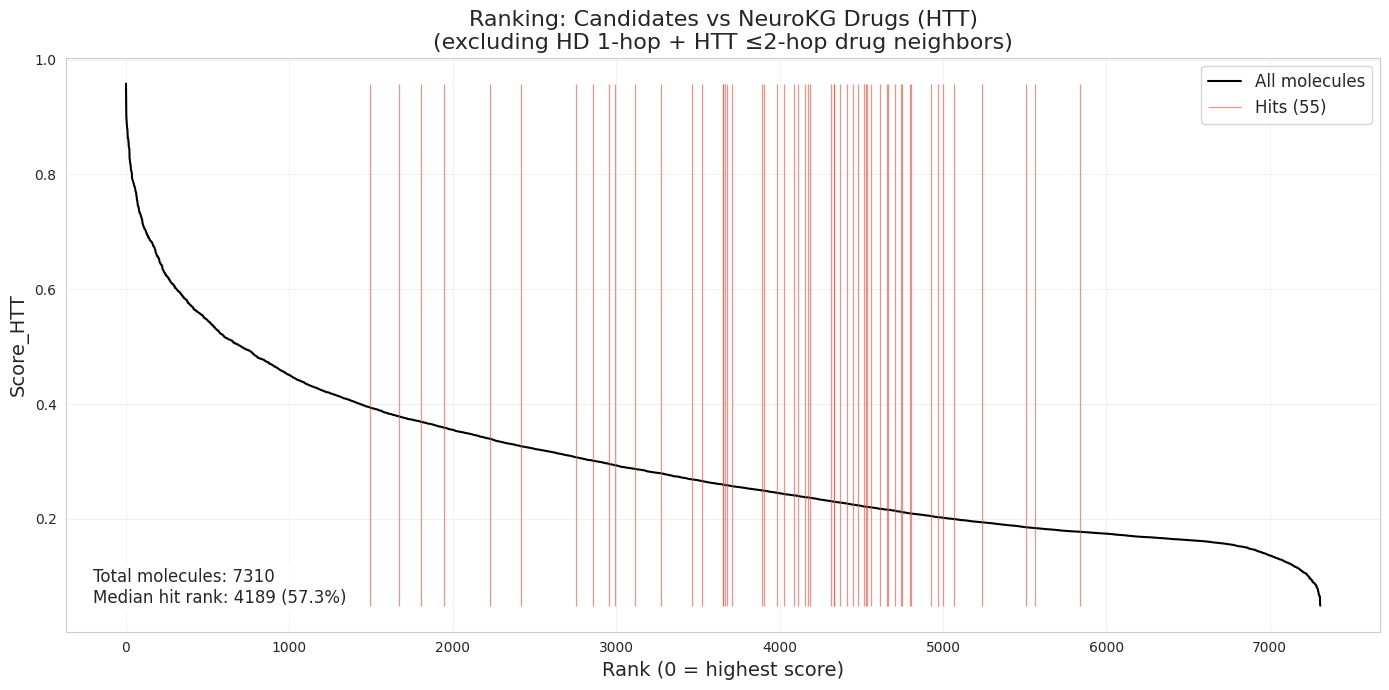

                    INFO     Saved ranking curve to                                               ]8;id=64057;file:///tmp/ipykernel_830620/1463998074.py\1463998074.py]8;;\:]8;id=507364;file:///tmp/ipykernel_830620/1463998074.py#120\120]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/m                  
                             olecular_analysis/hd_ranking_curve_with_background_excl_hd1hop_htt2h                  
                             op.png                                                                                

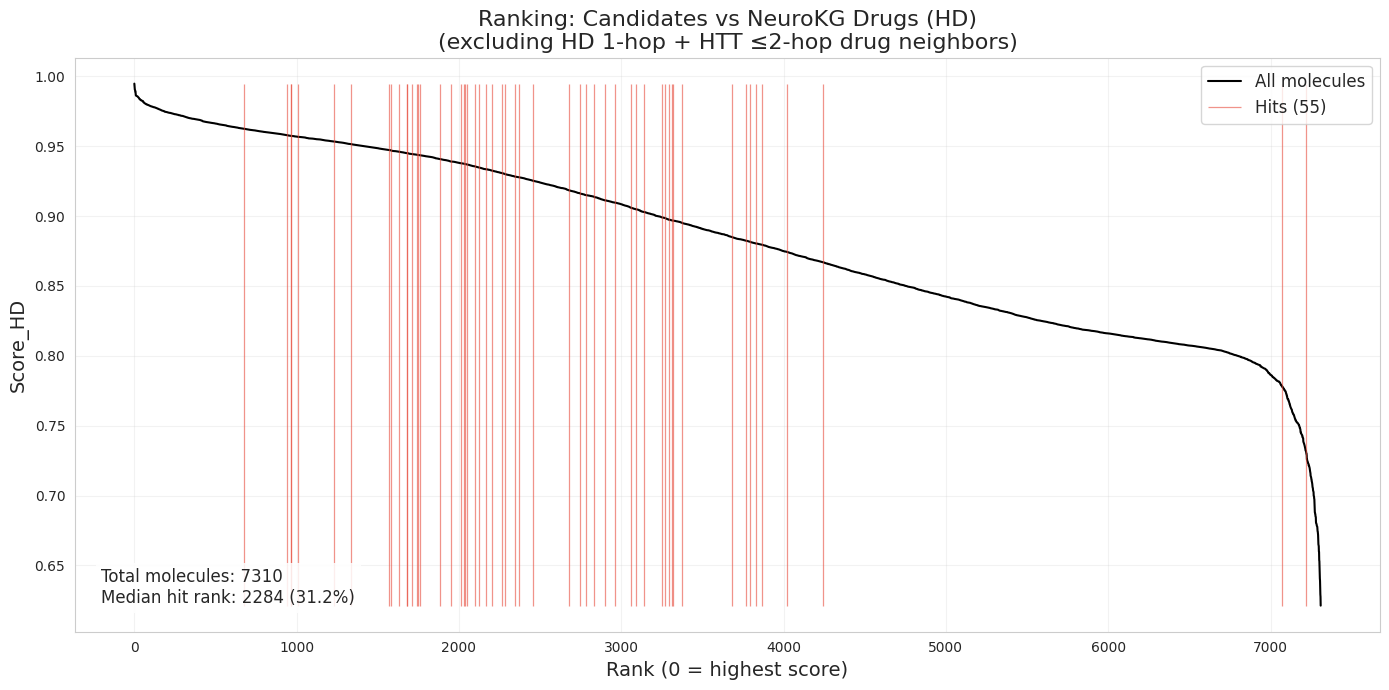


(
    <Figure size 1400x700 with 1 Axes>,
    <Axes: title={'center': 'Ranking: Candidates vs NeuroKG Drugs (HD)\n(excluding HD 1-hop + HTT ≤2-hop drug neighbors)'}, xlabel='Rank (0 = highest score)', ylabel='Score_HD'>
)

In [10]:
# --- Rank-vs-score curves excluding confounded drug neighborhoods in NeuroKG ---
# Reproduces the NeuroKG-background rank curves above, but filters out any *NeuroKG drug* node that is either:
#  (a) 1-hop connected to the "Huntington disease" node, OR
#  (b) within 2 hops of the HTT node (via any intermediate node types), based on the KG `edges` table.

if not ("nodes" in globals() and "edges" in globals()):
    raise RuntimeError("Expected `nodes` and `edges` to be loaded (see earlier cells).")
if "filtered_bg_drugs" not in globals():
    raise RuntimeError("Expected `filtered_bg_drugs` to exist (see NeuroKG background scoring cell).")
if "candidates_df" not in globals():
    raise RuntimeError("Expected `candidates_df` to exist (see candidate scoring cell).")
if "htt_idx" not in globals() or "hd_idx" not in globals():
    raise RuntimeError("Expected `htt_idx` and `hd_idx` to exist (see target-identification cell).")

# Drug index set (global indices)
drug_idx_set = set(nodes.loc[nodes["node_type"].astype(str) == "drug", "node_index"].astype(int).values)

def _one_hop_neighbors(seed_idx: int) -> set[int]:
    m = (edges["x_index"] == seed_idx) | (edges["y_index"] == seed_idx)
    if not m.any():
        return set()
    x = edges.loc[m, "x_index"].to_numpy()
    y = edges.loc[m, "y_index"].to_numpy()
    nbrs = set(np.concatenate([x, y]).astype(int))
    nbrs.discard(int(seed_idx))
    return nbrs

def _within_two_hops(seed_idx: int) -> set[int]:
    n1 = _one_hop_neighbors(seed_idx)
    if len(n1) == 0:
        return set()
    m2 = edges["x_index"].isin(n1) | edges["y_index"].isin(n1)
    x2 = edges.loc[m2, "x_index"].to_numpy()
    y2 = edges.loc[m2, "y_index"].to_numpy()
    n_within2 = set(np.concatenate([x2, y2]).astype(int))
    n_within2.discard(int(seed_idx))
    return n_within2

# --- Build exclusion set ---
hd_idx_int = int(hd_idx)
htt_idx_int = int(htt_idx)

hd_1hop_drugs = _one_hop_neighbors(hd_idx_int) & drug_idx_set
htt_within2_drugs = _within_two_hops(htt_idx_int) & drug_idx_set

excluded_drug_global_indices = hd_1hop_drugs | htt_within2_drugs

_logger.info(f"Huntington disease node idx: {hd_idx_int} | 1-hop drug neighbors: {len(hd_1hop_drugs)}")
_logger.info(f"HTT node idx: {htt_idx_int} | within-2-hop drug nodes: {len(htt_within2_drugs)}")
_logger.info(f"Excluding total unique NeuroKG drugs: {len(excluded_drug_global_indices)}")

if "node_index" not in filtered_bg_drugs.columns:
    raise RuntimeError("`filtered_bg_drugs` is missing `node_index` column; re-run the NeuroKG background scoring cell after updates.")

filtered_bg_drugs_excl = filtered_bg_drugs[~filtered_bg_drugs["node_index"].astype(int).isin(excluded_drug_global_indices)].copy()
_logger.info(f"Background drugs before exclusion: {len(filtered_bg_drugs)}")
_logger.info(f"Background drugs after exclusion: {len(filtered_bg_drugs_excl)}")

plot_cols = ['Score_HTT', 'Score_HD', 'pubchem_activity_outcome']
combined_ranking_df_excl_hd1hop_htt2hop = pd.concat(
    [candidates_df[plot_cols], filtered_bg_drugs_excl[plot_cols]],
    ignore_index=True,
 )

_logger.info(
    f"Combined DataFrame (exclusions applied): {len(combined_ranking_df_excl_hd1hop_htt2hop)} rows"
 )
display(combined_ranking_df_excl_hd1hop_htt2hop.head())

# Plot HTT (filtered)
plot_monotonically_decreasing(
    combined_ranking_df_excl_hd1hop_htt2hop,
    'Score_HTT',
    "Ranking: Candidates vs NeuroKG Drugs (HTT)\n(excluding HD 1-hop + HTT ≤2-hop drug neighbors)",
    "htt_ranking_curve_with_background_excl_hd1hop_htt2hop.png",
 )

# Plot HD (filtered)
plot_monotonically_decreasing(
    combined_ranking_df_excl_hd1hop_htt2hop,
    'Score_HD',
    "Ranking: Candidates vs NeuroKG Drugs (HD)\n(excluding HD 1-hop + HTT ≤2-hop drug neighbors)",
    "hd_ranking_curve_with_background_excl_hd1hop_htt2hop.png",
 )

In [11]:
# --- Recall @ K Plotting Function ---
def plot_recall_at_k(scores, active_indices, title, filename_suffix, k_values=[10, 20, 30, 40, 50]):
    """
    Plots Recall @ K where K is the top X% of the full sorted list.
    """
    # Sort scores descending
    sorted_indices = np.argsort(-scores) # Returns indices that sort the array
    total_items = len(scores)
    total_actives = len(active_indices)
    
    if total_actives == 0:
        _logger.warning(f"No actives found for Recall@K plot: {title}")
        return

    recalls = []
    labels = []
    
    for k in k_values:
        cutoff = int(total_items * k / 100)
        # Taking top 'cutoff' items
        top_k_indices = sorted_indices[:cutoff]
        
        # Count matches
        # Intersection of top_k_indices and active_indices
        recovered = np.isin(top_k_indices, active_indices).sum()
        recall = recovered / total_actives
        recalls.append(recall)
        labels.append(f"Top {k}%")
        
    # Plot
    plt.figure(figsize=(8, 6))
    # Gradient colors: light to dark blue
    # We use a palette and select colors from it
    base_palette = sns.color_palette("Blues", n_colors=len(k_values) + 2)
    colors = base_palette[2:] # Skip the very lightest ones
    
    bars = plt.bar(labels, recalls, color=colors, edgecolor='black', alpha=0.9)
    
    plt.title(f"Recall @ Top K% - {title}", fontsize=14)
    plt.ylabel("Recall (Fraction of Actives Recovered)", fontsize=12)
    plt.ylim(0, 1.1) 
    
    # Add text labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.2f}',
                 ha='center', va='bottom', fontsize=11, fontweight='bold')
                 
    output_path = PROJECT_ROOT / f"data/notebooks/molecular_analysis/recall_at_k_{filename_suffix}.png"
    plt.savefig(output_path)
    _logger.info(f"Saved Recall@K plot to {output_path}")
    plt.show()

In [12]:
# --- ChEMBL Background Analysis ---
# Benchmarking Huntington candidates against random ChEMBL molecules (decoys)

_logger.info("Starting ChEMBL Background Analysis...")

# 1. Load ChEMBL Background Data
chembl_csv_path = PROJECT_ROOT / "notebooks/molecular_analysis/filtered_chembl_gba1_merged_filtered_molecules_with_embeddings.csv"
chembl_emb_path = PROJECT_ROOT / "notebooks/molecular_analysis/filtered_chembl_gba1_merged_embeddings.pt"
gba1_ref_path = PROJECT_ROOT / "data/neurokg/drugs/GBA1_hits_with_embeddings.csv"

# Load Embeddings
_logger.info(f"Loading ChEMBL/Merged embeddings from {chembl_emb_path}")
merged_chembl_embeddings = torch.load(chembl_emb_path, map_location='cpu')

# Load Metadata
_logger.info(f"Loading ChEMBL/Merged metadata from {chembl_csv_path}")
chembl_df = pd.read_csv(chembl_csv_path)

# Filter out GBA1 hits from this background set to get "pure" ChEMBL decoys
# (Reusing logic from GBA1 notebook to ensure clean background)
try:
    if gba1_ref_path.exists():
        gba1_ref_df = pd.read_csv(gba1_ref_path)
        # Normalize columns
        chembl_df.columns = [c.lower() for c in chembl_df.columns]
        
        # Determine IDs to exclude
        if 'Sample Data Type' in gba1_ref_df.columns:
            ref_ids = set(gba1_ref_df['Sample Data Type'].astype(str).str.strip().values)
        else:
            ref_ids = set(gba1_ref_df.iloc[:, 0].astype(str).str.strip().values)
            
        # Filter
        merged_ids = chembl_df['id'].astype(str).str.strip()
        is_gba1_hit = merged_ids.isin(ref_ids)
        chembl_indices = np.where(~is_gba1_hit)[0]
        
        _logger.info(f"Filtered out {is_gba1_hit.sum()} GBA1 hits from background.")
        _logger.info(f"Remaining ChEMBL Decoys: {len(chembl_indices)}")
        
        # Subset embeddings and dataframe
        chembl_embeddings = merged_chembl_embeddings[chembl_indices]
        chembl_df = chembl_df.iloc[chembl_indices].reset_index(drop=True)
    else:
        _logger.warning("GBA1 hits usage file not found. Using full merged set as background.")
        chembl_embeddings = merged_chembl_embeddings
except Exception as e:
    _logger.warning(f"Error filtering GBA1 hits: {e}. Using full background.")
    chembl_embeddings = merged_chembl_embeddings

_logger.info(f"Final ChEMBL Background Shape: {chembl_embeddings.shape}")

[02/05/26 00:50:06] INFO     Starting ChEMBL Background Analysis...                                  ]8;id=141832;file:///tmp/ipykernel_830620/237544523.py\237544523.py]8;;\:]8;id=904742;file:///tmp/ipykernel_830620/237544523.py#4\4]8;;\

                    INFO     Loading ChEMBL/Merged embeddings from                                  ]8;id=772193;file:///tmp/ipykernel_830620/237544523.py\237544523.py]8;;\:]8;id=464352;file:///tmp/ipykernel_830620/237544523.py#12\12]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/notebooks/molecula                
                             r_analysis/filtered_chembl_gba1_merged_embeddings.pt                                  

                    INFO     Loading ChEMBL/Merged metadata from                                    ]8;id=182183;file:///tmp/ipykernel_830620/237544523.py\237544523.py]8;;\:]8;id=627916;file:///tmp/ipykernel_830620/237544523.py#16\16]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/notebooks/molecula                
                             r_analysis/filtered_chembl_gba1_merged_filtered_molecules_with_embeddi                
                             ngs.csv                                                                               

                    INFO     Filtered out 72 GBA1 hits from background.                             ]8;id=427025;file:///tmp/ipykernel_830620/237544523.py\237544523.py]8;;\:]8;id=698866;file:///tmp/ipykernel_830620/237544523.py#38\38]8;;\

                    INFO     Remaining ChEMBL Decoys: 28495                                         ]8;id=405055;file:///tmp/ipykernel_830620/237544523.py\237544523.py]8;;\:]8;id=659555;file:///tmp/ipykernel_830620/237544523.py#39\39]8;;\

                    INFO     Final ChEMBL Background Shape: torch.Size([28495, 512])                ]8;id=572458;file:///tmp/ipykernel_830620/237544523.py\237544523.py]8;;\:]8;id=818397;file:///tmp/ipykernel_830620/237544523.py#51\51]8;;\

In [13]:
# 2. Combine Embeddings and Score against Targets
# Structure: [Pretrained (Graph Nodes)] + [Huntington Candidates] + [ChEMBL Decoys]

_logger.info("Combining embeddings for scoring...")

# res_embeddings = Huntington Candidates (from earlier cells)
# chembl_embeddings = ChEMBL Decoys

# Concatenate: Pretrained + Candidates + ChEMBL
full_analysis_embeddings = torch.cat([pretrained_embeddings, res_embeddings, chembl_embeddings], dim=0)

num_pretrained = len(pretrained_embeddings)
num_candidates = len(res_embeddings)
num_chembl = len(chembl_embeddings)

# Indices definitions
candidate_indices_full = torch.arange(num_pretrained, num_pretrained + num_candidates, dtype=torch.long)
chembl_indices_full = torch.arange(num_pretrained + num_candidates, num_pretrained + num_candidates + num_chembl, dtype=torch.long)
# All evaluation molecules together (for ranking curve)
all_eval_indices = torch.cat([candidate_indices_full, chembl_indices_full])

_logger.info(f"Full Embeddings Shape: {full_analysis_embeddings.shape}")
_logger.info(f"Scoring {len(all_eval_indices)} molecules ({num_candidates} Candidates + {num_chembl} Decoys)...")

def score_against_target_chembl_bg(target_idx, target_name, etype):
    # Batch Score: All Eval Molecules -> Target
    batch_src = all_eval_indices
    batch_dst = torch.full((len(all_eval_indices),), target_idx, dtype=torch.long)
    
    with torch.no_grad():
        scores = pretrain_model.get_scores_from_embeddings(
            batch_src, 
            batch_dst, 
            etype, 
            embeddings=full_analysis_embeddings, 
            use_cache=False, 
            query_kg=kg
        )
    return scores.cpu().numpy()

# A. Score vs HTT protein
_logger.info("Scoring against HTT Protein...")
scores_htt_all = score_against_target_chembl_bg(htt_idx, "HTT", ("drug", "drug_protein", "gene/protein"))

# B. Score vs Huntington Disease
_logger.info("Scoring against Huntington Disease...")
scores_hd_all = score_against_target_chembl_bg(hd_idx, "Huntington Disease", ("drug", "rev_indication", "disease"))

_logger.info("Scoring complete.")

                    INFO     Combining embeddings for scoring...                                    ]8;id=59674;file:///tmp/ipykernel_830620/1441544052.py\1441544052.py]8;;\:]8;id=239419;file:///tmp/ipykernel_830620/1441544052.py#4\4]8;;\

                    INFO     Full Embeddings Shape: torch.Size([175570, 512])                      ]8;id=95208;file:///tmp/ipykernel_830620/1441544052.py\1441544052.py]8;;\:]8;id=357458;file:///tmp/ipykernel_830620/1441544052.py#22\22]8;;\

                    INFO     Scoring 28550 molecules (55 Candidates + 28495 Decoys)...             ]8;id=163178;file:///tmp/ipykernel_830620/1441544052.py\1441544052.py]8;;\:]8;id=713271;file:///tmp/ipykernel_830620/1441544052.py#23\23]8;;\

                    INFO     Scoring against HTT Protein...                                        ]8;id=325529;file:///tmp/ipykernel_830620/1441544052.py\1441544052.py]8;;\:]8;id=120647;file:///tmp/ipykernel_830620/1441544052.py#42\42]8;;\

                    INFO     Scoring against Huntington Disease...                                 ]8;id=111802;file:///tmp/ipykernel_830620/1441544052.py\1441544052.py]8;;\:]8;id=433137;file:///tmp/ipykernel_830620/1441544052.py#46\46]8;;\

                    INFO     Scoring complete.                                                     ]8;id=927485;file:///tmp/ipykernel_830620/1441544052.py\1441544052.py]8;;\:]8;id=583783;file:///tmp/ipykernel_830620/1441544052.py#49\49]8;;\

                    INFO     Saved plot to                                                          ]8;id=698734;file:///tmp/ipykernel_830620/952074595.py\952074595.py]8;;\:]8;id=714094;file:///tmp/ipykernel_830620/952074595.py#68\68]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mol                
                             ecular_analysis/htt_ranking_vs_chembl.png                                             

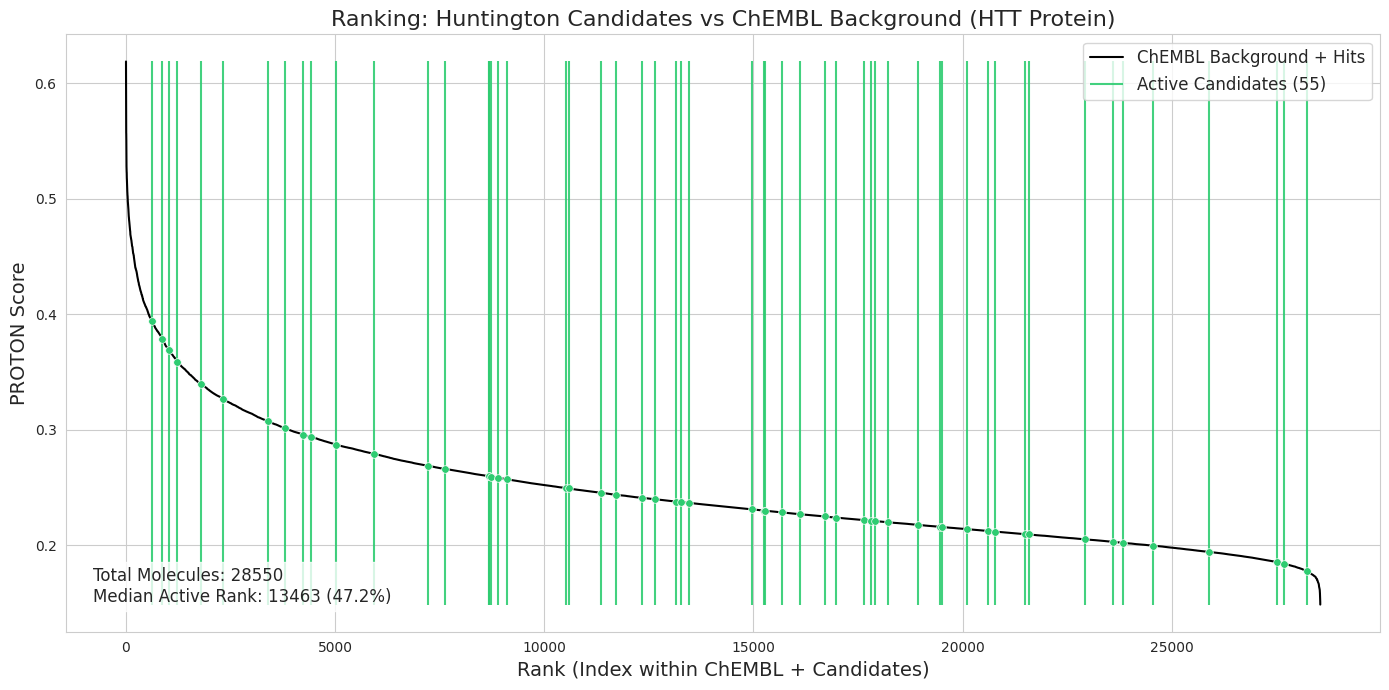

[02/05/26 00:50:07] INFO     Saved plot to                                                          ]8;id=951858;file:///tmp/ipykernel_830620/952074595.py\952074595.py]8;;\:]8;id=687333;file:///tmp/ipykernel_830620/952074595.py#68\68]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mol                
                             ecular_analysis/hd_ranking_vs_chembl.png                                              

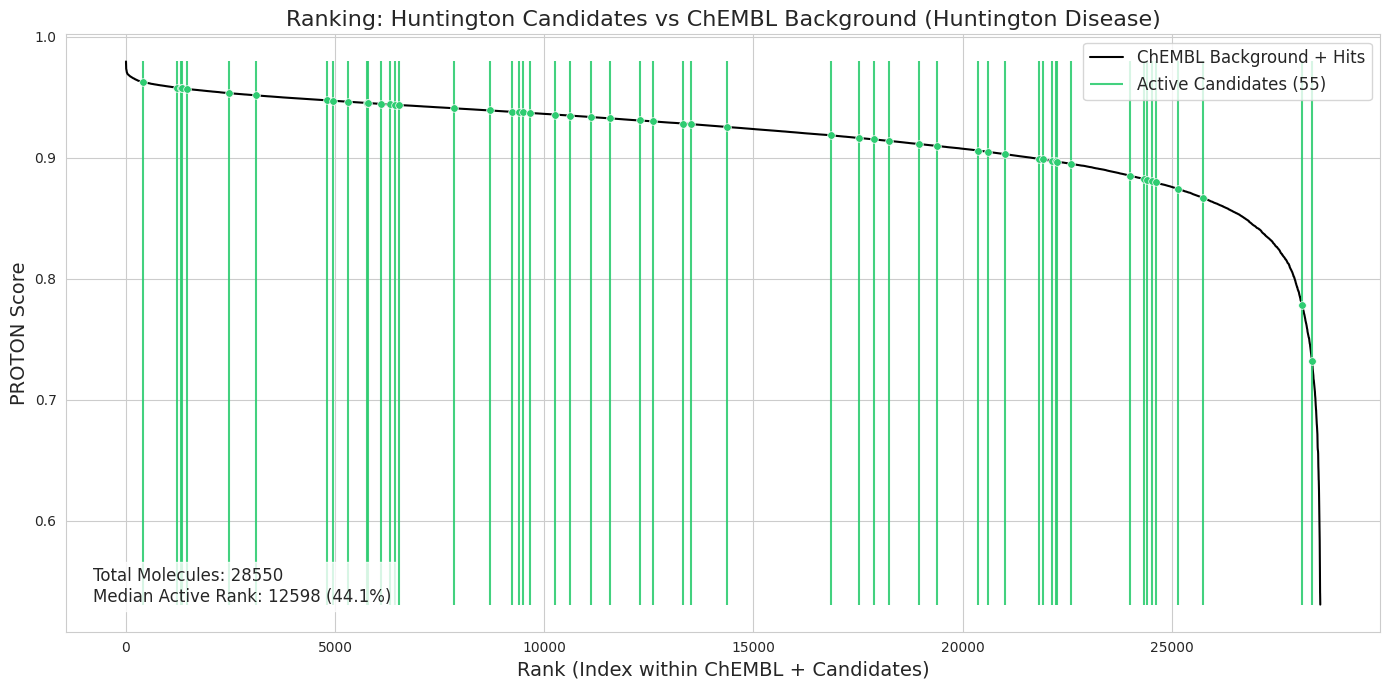

In [14]:
# 3. Visualization: Hits vs ChEMBL Background
# We plot the ranking curve of ALL molecules (ChEMBL + Hits)
# And highlight the active/inactive hits

def plot_chembl_benchmarking(all_scores, title, filename):
    # Sort scores descending
    sorted_indices = np.argsort(-all_scores)
    sorted_scores = all_scores[sorted_indices]
    
    # Identify positions of Active and Inactive Candidates in the sorted list
    # candidate_indices_full corresponds to the FIRST 'num_candidates' elements of 'all_scores'
    # (since we concatenated candidates first, then chembl)
    
    # Map from original index (0..total-1) to sorted rank
    # We need to know which of the original indices correspond to Actives/Inactives
    
    # Get local indices (0 to num_candidates-1) of actives/inactives from original dataframe
    active_local_idx = candidates_df.index[candidates_df['pubchem_activity_outcome'].str.lower().str.strip() == 'active'].values
    inactive_local_idx = candidates_df.index[candidates_df['pubchem_activity_outcome'].str.lower().str.strip() == 'inactive'].values
    
    # Convert to indices in 'all_scores' array
    # Candidates are at the start of all_scores (indices 0 to num_candidates)
    active_indices_global = active_local_idx
    inactive_indices_global = inactive_local_idx
    
    # Find these global indices in the SORTED list
    is_active_sorted = np.isin(sorted_indices, active_indices_global)
    is_inactive_sorted = np.isin(sorted_indices, inactive_indices_global)
    
    active_ranks = np.where(is_active_sorted)[0]
    inactive_ranks = np.where(is_inactive_sorted)[0]
    
    active_scores_sorted = sorted_scores[is_active_sorted]
    inactive_scores_sorted = sorted_scores[is_inactive_sorted]
    
    # Plot
    plt.figure(figsize=(14, 7))
    
    # Background Curve (Black)
    plt.plot(np.arange(len(sorted_scores)), sorted_scores, color='black', linewidth=1.5, label='ChEMBL Background + Hits')
    
    # Highlight Inactives (Red)
    if len(inactive_ranks) > 0:
        plt.vlines(inactive_ranks, ymin=min(sorted_scores), ymax=max(sorted_scores), 
                   color='#E74C3C', alpha=0.4, linewidth=0.8, label=f'Inactive Candidates ({len(inactive_ranks)})')

    # Highlight Actives (Green)
    if len(active_ranks) > 0:
        plt.vlines(active_ranks, ymin=min(sorted_scores), ymax=max(sorted_scores), 
                   color='#2ECC71', alpha=0.9, linewidth=1.5, label=f'Active Candidates ({len(active_ranks)})')
        plt.scatter(active_ranks, active_scores_sorted, color='#2ECC71', s=30, zorder=5, edgecolors='white', linewidth=0.5)

    plt.title(title, fontsize=16)
    plt.xlabel("Rank (Index within ChEMBL + Candidates)", fontsize=14)
    plt.ylabel("PROTON Score", fontsize=14)
    plt.legend(loc="upper right", fontsize=12)
    
    # Add stats annotation
    median_active = np.median(active_ranks) if len(active_ranks) > 0 else 0
    total_mols = len(sorted_scores)
    stats_text = f"Total Molecules: {total_mols}\nMedian Active Rank: {median_active:.0f} ({median_active/total_mols*100:.1f}%)"
    plt.text(0.02, 0.05, stats_text, transform=plt.gca().transAxes, fontsize=12, 
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    output_path = PROJECT_ROOT / f"data/notebooks/molecular_analysis/{filename}"
    plt.savefig(output_path)
    _logger.info(f"Saved plot to {output_path}")
    plt.show()

# Plot vs HTT
plot_chembl_benchmarking(
    scores_htt_all, 
    "Ranking: Huntington Candidates vs ChEMBL Background (HTT Protein)", 
    "htt_ranking_vs_chembl.png"
)

# Plot vs HD
plot_chembl_benchmarking(
    scores_hd_all, 
    "Ranking: Huntington Candidates vs ChEMBL Background (Huntington Disease)", 
    "hd_ranking_vs_chembl.png"
)

                    INFO     Computing Recall @ K for NeuroKG background...                         ]8;id=928094;file:///tmp/ipykernel_830620/3871507155.py\3871507155.py]8;;\:]8;id=774112;file:///tmp/ipykernel_830620/3871507155.py#3\3]8;;\

                    INFO     Saved Recall@K plot to                                                ]8;id=622321;file:///tmp/ipykernel_830620/1373267798.py\1373267798.py]8;;\:]8;id=241683;file:///tmp/ipykernel_830620/1373267798.py#52\52]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_neurokg_htt.png                                          

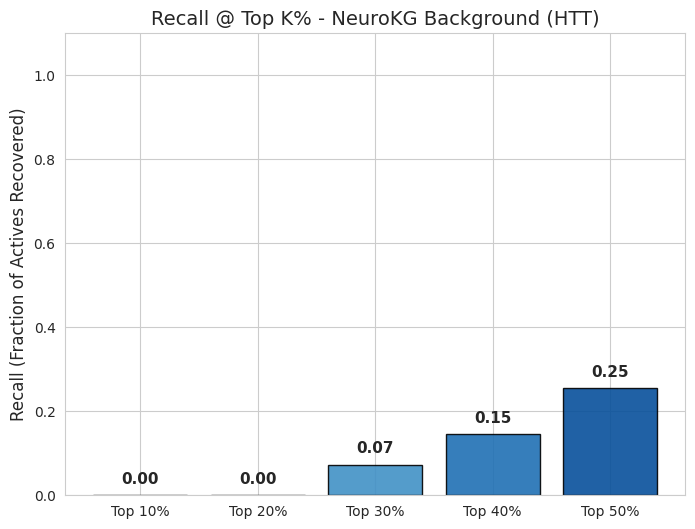

                    INFO     Saved Recall@K plot to                                                ]8;id=461909;file:///tmp/ipykernel_830620/1373267798.py\1373267798.py]8;;\:]8;id=238512;file:///tmp/ipykernel_830620/1373267798.py#52\52]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_neurokg_hd.png                                           

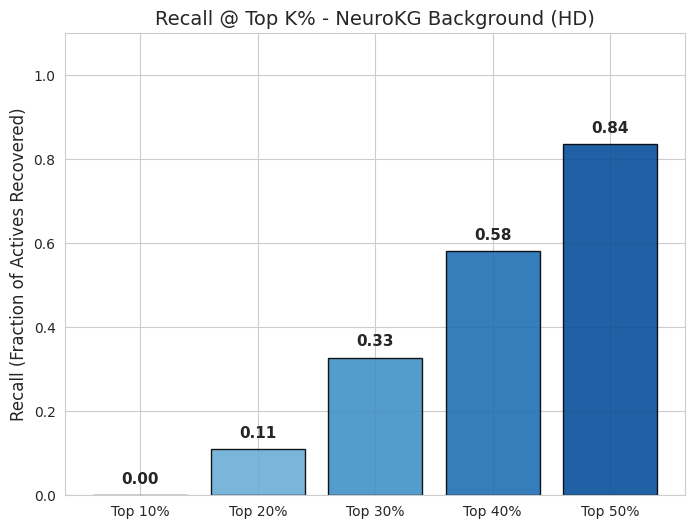

                    INFO     Computing Recall @ K for FILTERED NeuroKG background (exclusions      ]8;id=661361;file:///tmp/ipykernel_830620/3871507155.py\3871507155.py]8;;\:]8;id=735135;file:///tmp/ipykernel_830620/3871507155.py#29\29]8;;\
                             applied)...                                                                           

                    INFO     Saved Recall@K plot to                                                ]8;id=701720;file:///tmp/ipykernel_830620/1373267798.py\1373267798.py]8;;\:]8;id=6636;file:///tmp/ipykernel_830620/1373267798.py#52\52]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_neurokg_htt_excl_hd1hop_htt2hop.png                      

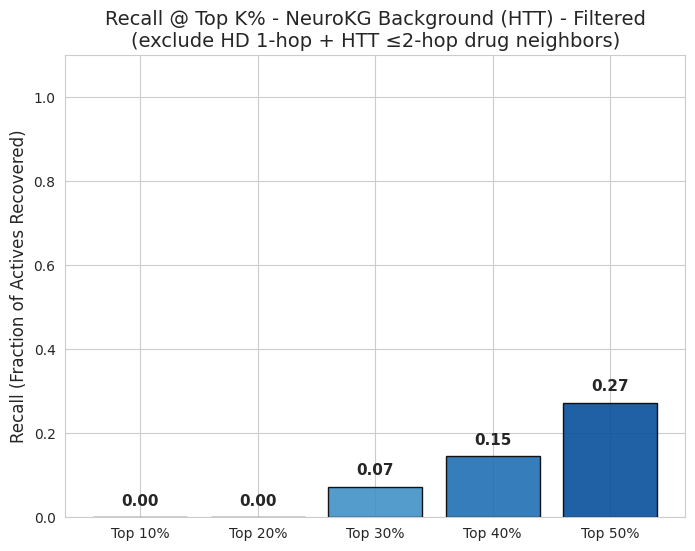

[02/05/26 00:50:08] INFO     Saved Recall@K plot to                                                ]8;id=133818;file:///tmp/ipykernel_830620/1373267798.py\1373267798.py]8;;\:]8;id=979610;file:///tmp/ipykernel_830620/1373267798.py#52\52]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_neurokg_hd_excl_hd1hop_htt2hop.png                       

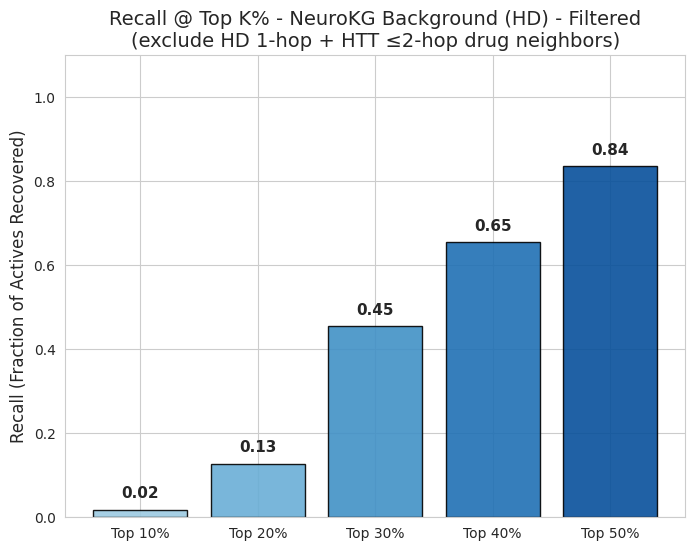

In [15]:
# Use combined_ranking_df for Recall analysis
# Identify active indices in the combined DataFrame
_logger.info("Computing Recall @ K for NeuroKG background...")
active_bg_mask = combined_ranking_df['pubchem_activity_outcome'].astype(str).str.strip().str.lower() == 'active'
active_bg_indices = np.where(active_bg_mask)[0]

# Scores arrays from DF
scores_htt_bg = combined_ranking_df['Score_HTT'].values
scores_hd_bg = combined_ranking_df['Score_HD'].values

# Plot HTT
plot_recall_at_k(
    scores=scores_htt_bg,
    active_indices=active_bg_indices,
    title="NeuroKG Background (HTT)",
    filename_suffix="neurokg_htt"
 )

# Plot HD
plot_recall_at_k(
    scores=scores_hd_bg,
    active_indices=active_bg_indices,
    title="NeuroKG Background (HD)",
    filename_suffix="neurokg_hd"
 )

# --- Filtered Recall @ K (exclusions applied to NeuroKG background) ---
if "combined_ranking_df_excl_hd1hop_htt2hop" in globals():
    _logger.info("Computing Recall @ K for FILTERED NeuroKG background (exclusions applied)...")
    combined_excl = combined_ranking_df_excl_hd1hop_htt2hop
    active_excl_mask = combined_excl['pubchem_activity_outcome'].astype(str).str.strip().str.lower() == 'active'
    active_excl_indices = np.where(active_excl_mask)[0]
    
    scores_htt_bg_excl = combined_excl['Score_HTT'].values
    scores_hd_bg_excl = combined_excl['Score_HD'].values
    
    plot_recall_at_k(
        scores=scores_htt_bg_excl,
        active_indices=active_excl_indices,
        title="NeuroKG Background (HTT) - Filtered\n(exclude HD 1-hop + HTT ≤2-hop drug neighbors)",
        filename_suffix="neurokg_htt_excl_hd1hop_htt2hop",
    )
    
    plot_recall_at_k(
        scores=scores_hd_bg_excl,
        active_indices=active_excl_indices,
        title="NeuroKG Background (HD) - Filtered\n(exclude HD 1-hop + HTT ≤2-hop drug neighbors)",
        filename_suffix="neurokg_hd_excl_hd1hop_htt2hop",
    )
else:
    _logger.warning(
        "Skipping FILTERED NeuroKG Recall analysis: `combined_ranking_df_excl_hd1hop_htt2hop` missing (run the filtered rank-curve cell first)."
    )

                    INFO     Computing Recall @ K for ChEMBL background...                          ]8;id=822432;file:///tmp/ipykernel_830620/1487210272.py\1487210272.py]8;;\:]8;id=584444;file:///tmp/ipykernel_830620/1487210272.py#4\4]8;;\

                    INFO     Saved Recall@K plot to                                                ]8;id=726915;file:///tmp/ipykernel_830620/1373267798.py\1373267798.py]8;;\:]8;id=586988;file:///tmp/ipykernel_830620/1373267798.py#52\52]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_chembl_htt.png                                           

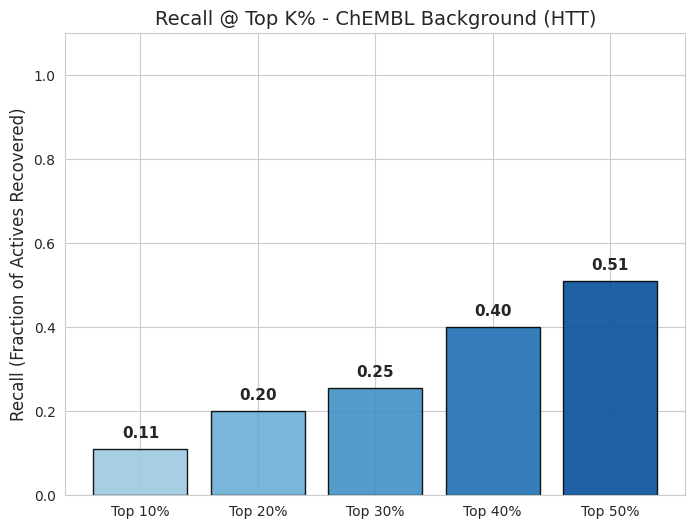

                    INFO     Saved Recall@K plot to                                                ]8;id=449877;file:///tmp/ipykernel_830620/1373267798.py\1373267798.py]8;;\:]8;id=64803;file:///tmp/ipykernel_830620/1373267798.py#52\52]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_chembl_hd.png                                            

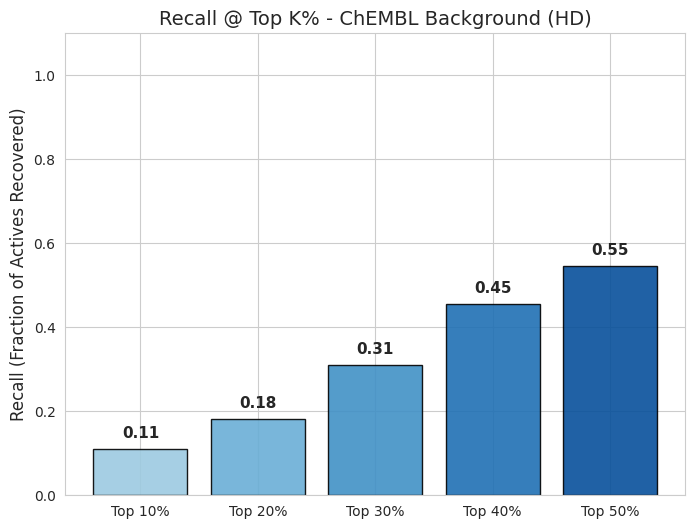

In [16]:
# Use ChEMBL scores for Recall analysis
# Identify active indices in the full evaluation list (Candidates + ChEMBL)
# Actives are inside 'candidates' part, which is the first block
_logger.info("Computing Recall @ K for ChEMBL background...")

# We need positions of actives in the [Candidates + ChEMBL] array
# 'candidates_df' (which corresponds to first part of array) has active status
if 'pubchem_activity_outcome' in candidates_df.columns:
    active_local = candidates_df['pubchem_activity_outcome'].astype(str).str.strip().str.lower() == 'active'
    active_local_indices = np.where(active_local)[0]
    # Since candidates are at the start of the combined array, these are the global indices too
    active_chembl_indices = active_local_indices
else:
    active_chembl_indices = []

# Plot HTT
plot_recall_at_k(
    scores=scores_htt_all,
    active_indices=active_chembl_indices,
    title="ChEMBL Background (HTT)",
    filename_suffix="chembl_htt"
)

# Plot HD
plot_recall_at_k(
    scores=scores_hd_all,
    active_indices=active_chembl_indices,
    title="ChEMBL Background (HD)",
    filename_suffix="chembl_hd"
)